# Assignment 2
Look for any information about gene 'PGM1' (encoding Phosphoglucomutase 1) in the NCBI database 'gene' and print the output. Mutations in this gene cause glycogen storage disease. PGM1 is an evolutionarily conserved enzyme that regulates one of the most important metabolic carbohydrate trafficking points in prokaryotic and eukaryotic organisms.

Deficiency is an inherited metabolic disorder in humans (cause of Congenital disorder of glycosylation). Affected patients show multiple disease phenotypes, including dilated cardiomyopathy, exercise intolerance, and hepatopathy, reflecting the central role of the enzyme in glucose metabolism

## Libraries

In [1]:
from Bio import Entrez
from pprint import pprint
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from tqdm.notebook import tqdm
import re 
import pandas as pd
import geopandas as gpd 
import collections
import mapclassify as mc

pd.set_option('display.max_rows', 180)
pd.options.mode.chained_assignment = None 


Bad key "text.kerning_factor" on line 4 in
/Users/villons/opt/anaconda3/envs/biosciences/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Functions

In [15]:
Entrez.email = "giacomo.villa.mi@gmail.com"
starting_path = os.getcwd()
plt.style.use('seaborn')

def info():
    handle = Entrez.einfo()
    result = Entrez.read(handle)
    dbs = result['DbList']
    print("Avaible database:")
    for db in dbs:
        print(db.capitalize(), end = ", ")
    print()
    print("FOR REASEARCH ALL LOWERCASE!")

def db_info(db):
    handle = Entrez.einfo(db = db)
    record = Entrez.read(handle)
    print(pprint(record['DbInfo']))
        
def good_print(text):
    print(pprint(text))
        
def esearch(db, query, num_max = 20):
    handle = Entrez.esearch(db = db, term = query, retmax = num_max)
    record = Entrez.read(handle, validate = True)
    return record

def esummary(db, id_val):
    handle = Entrez.esummary(db = db, id = id_val)
    record = Entrez.read(handle, validate = True)
    return record

def efetch(db, id_val, retmode = 'xml'):
    handle = Entrez.efetch(db  = db, id = id_val, retmode = retmode)
    record = Entrez.read(handle, validate = True)
    return record

def get_idList(record):
    return record['IdList']

def save_img(title):    
    plt.savefig('./images/analysis_images/'+title+'.png', dpi = 300, quality = 95, format = 'png', pad_inches = 500)

def plot_num_file_for_species(ids):
    
    species = dict()
    position = 0

    for file_id in tqdm(ids, desc = 'Gene files processed'):
        summary = esummary('gene', file_id)
        specie = summary['DocumentSummarySet']['DocumentSummary'][0]['Organism']['ScientificName']
        specie = specie.lower()
        if specie in species:
            species[specie] += 1
        else:
            species[specie] = 1
    
    ordered = {k: v for k, v in sorted(species.items(), key=lambda item: item[1])}
    species_name = list()
    values = list()
    for info in list(ordered)[len(ordered)-10:len(ordered)]:
        species_name.append(info)
        values.append(ordered[info])
        
    fig, ax = plt.subplots()
    
    ax.barh(species_name, values)
    
    for i, v in enumerate(values):
        ax.text(v, i - .05, str(v), color='black', fontweight='bold', ha='left')
        
    ax.set_xlabel('Number of Gene file')
    plt.title('Comparison of Gene file number about PGM1 gene')

    ax.grid(True)
    plt.subplots_adjust(left=0.25)
    save_img('number_of_gene_file')
    plt.show()   
    
def word_cloud(words):
    
    papers_mask = np.array(Image.open("./images/papers.png"))
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                          mode="RGBA", max_words=2000, mask = papers_mask).generate(words)

    image_colors = ImageColorGenerator(papers_mask)
    
    return wordcloud, image_colors

def plot_papers_title(ids):
    titles = list()
    for paper_id in tqdm(ids, desc = 'Papers processed'):
        summary = esummary('pubmed', paper_id)
        titles.append(summary[0]['Title'])
        
    wordcloud, colors = word_cloud(' '.join(titles))
    fig, ax = plt.subplots(figsize=[20,20])
    plt.title('Word Cloud about PGM1 title papers')
    ax.axis("off")
    
    
    ax.imshow(wordcloud.recolor(color_func=colors), interpolation="bilinear")
    wordcloud.to_file("./images/analysis_images/title_word_cloud.png")

    plt.show()
    
def plot_abstract(ids):
    abstracts = list()
    for paper_id in tqdm(ids, desc = 'Papers processed'):
        fetch = efetch('pubmed', paper_id)
        try:
            if fetch['PubmedArticle'] == []:
                abstracts.appendstr(fetch['PubmedBookArticle'][0]['BookDocument']
                                    ['Abstract']['AbstractText'][0])
            else: 
                abstracts.append(fetch['PubmedArticle'][0]['MedlineCitation']['Article']
                                 ['Abstract']['AbstractText'][0])
        except:
            pass
        
    wordcloud, colors = word_cloud(' '.join(abstracts))
    fig, ax = plt.subplots(figsize=[20,20])
    plt.title('Word Cloud about PGM1 papers abstracts')
    ax.axis("off")
    
    
    ax.imshow(wordcloud.recolor(color_func=colors), interpolation="bilinear")
    wordcloud.to_file("./images/analysis_images/abstract_word_cloud.png")

    plt.show()
    
def num_paper_for_year(ids):
    df = pd.DataFrame(columns=['year'])
    intervals_years = dict()
    intervals_years['1969-1974'] = 0 
    intervals_years['1975-1979'] = 0 
    intervals_years['1980-1984'] = 0 
    intervals_years['1985-1989'] = 0 
    intervals_years['1990-1994'] = 0 
    intervals_years['1995-1999'] = 0 
    intervals_years['2000-2004'] = 0 
    intervals_years['2005-2009'] = 0 
    intervals_years['2010-2014'] = 0 
    intervals_years['2015-2020'] = 0 

    for paper_id in tqdm(ids, desc = 'Papers processed'):
        fetch = fetch = efetch('pubmed', paper_id)
        try:
            year = fetch['PubmedArticle'][0]['PubmedData']['History'][0]['Year']
        except:
            year = fetch['PubmedBookArticle'][0]['PubmedBookData']['History'][0]['Year']
        year = int(year)
        if year >= 1969 and year <= 1974:
            intervals_years['1969-1974'] += 1
        elif year >= 1975 and year <= 1979:
            intervals_years['1975-1979'] += 1
        elif year >= 1980 and year <= 1984:
            intervals_years['1980-1984'] += 1
        elif year >= 1985 and year <= 1989:
            intervals_years['1985-1989'] += 1
        elif year >= 1990 and year <= 1994:
            intervals_years['1990-1994'] += 1
        elif year >= 1995 and year <= 1999:
            intervals_years['1995-1999'] += 1
        elif year >= 2000 and year <= 2004:
            intervals_years['2000-2004'] += 1
        elif year >= 2005 and year <= 2009:
            intervals_years['2005-2009'] += 1
        elif year >= 2010 and year <= 2014:
            intervals_years['2010-2014'] += 1
        else:
            intervals_years['2015-2020'] += 1
        
    years = list(intervals_years.keys())
    nums = list(intervals_years.values())


    fig, ax = plt.subplots()
    fig.set_size_inches(10,8)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.plot(years, nums, color='black', marker='o', label = 'Number of Papers')
    
    ax.legend()
    ax.set_title('Number of Papers for Year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number')
    save_img('Number_of_papers_for_year')
    
    
    plt.show()

def plot_on_world(ids):
    shapefile = './world_map/ne_110m_admin_0_countries.shp'
    gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
    gdf.columns = ['country', 'country_code', 'geometry']
    gdf.set_index('country', inplace = True)

    total = [0]*gdf.shape[0]
    for paper_id in tqdm(ids, desc = 'Papers processed'):
        fetch = efetch('pubmed', paper_id)
        try:
            country = fetch['PubmedArticle'][0]['MedlineCitation']['MedlineJournalInfo']['Country']
        except:
            print(paper_id)

        if country == 'England' or country == 'Scotland':
            total[gdf.index.get_loc('United Kingdom')] += 1  
        elif country == 'United States':
            total[gdf.index.get_loc('United States of America')] += 1  
        elif country == "Czech Republic":
            total[gdf.index.get_loc('Czechia')] += 1   
        elif country == "Russia (Federation)":
            total[gdf.index.get_loc('Russia')] += 1   
        else:    
            total[gdf.index.get_loc(country)] += 1  
            
    for i in range (0, len(total)):
        if total[i] > 0:
            total[i] = np.log(total[i])
            
    gdf['values'] = total

    fig, ax1 = plt.subplots(figsize=(15, 10))

    ax1.set_axis_off()
    ax1.set_title("Papers per Country")

    gdf.plot(column='values', ax = ax1, legend = True, linewidth=1, alpha=0.8, cmap = "Oranges",
             legend_kwds={'label': 'ln(Number of publication)'}, edgecolor = "black")


    plt.axis('equal')
    save_img('Plot_papers_on_the_world')
    plt.show()
    
def plot_papers_lang(ids):
    language = dict()

    for paper_id in tqdm(ids, desc = 'Papers processed'):
        fetch = efetch('pubmed', paper_id)
        try:
            lang = fetch['PubmedArticle'][0]['MedlineCitation']['Article']['Language'][0]
        except:
            print(paper_id)

        if lang in language:
            language[lang] += 1
        else:
            language[lang] = 1

    languages = list(language.keys())
    values = list(language.values())
    
    fig, ax1 = plt.subplots()
    
    ax1.set_title('Papers language')
    
    ax1.barh(languages, values)
    for i, v in enumerate(values):
        ax1.text(v, i - .05, str(v), color='black', fontweight='bold', ha='left')
    
    save_img('plot_lang_for_papers')
    plt.show()
    
def plot_gene_files(ids):
    gene_for_year = dict()
    for paper_id in tqdm(ids, desc = 'Papers processed'):
        fetch = efetch('gene', paper_id)
        try:
            year = fetch[0]['Entrezgene_track-info']['Gene-track']['Gene-track_create-date']['Date']['Date_std']['Date-std']['Date-std_year']
        except:
            print(paper_id)

        if year in gene_for_year:
            gene_for_year[year] += 1
        else:
            gene_for_year[year] = 1

    ordered_gene_for_year = collections.OrderedDict(sorted(gene_for_year.items()))

    years = list(ordered_gene_for_year.keys())
    values = list(ordered_gene_for_year.values())

    fig, ax = plt.subplots()
    fig.set_size_inches(10,8)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.plot(years, values, color='black', marker='o', label = 'Number of Gene files')

    ax.legend()
    ax.set_title('Number of Gene files for Year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number')
    save_img('Number_of_gene_files_for_year')


    plt.show()

## Main

### Print some useful info

In [3]:
info()
db_info('gene')

Avaible database:
Pubmed, Protein, Nuccore, Ipg, Nucleotide, Structure, Sparcle, Genome, Annotinfo, Assembly, Bioproject, Biosample, Blastdbinfo, Books, Cdd, Clinvar, Gap, Gapplus, Grasp, Dbvar, Gene, Gds, Geoprofiles, Homologene, Medgen, Mesh, Ncbisearch, Nlmcatalog, Omim, Orgtrack, Pmc, Popset, Probe, Proteinclusters, Pcassay, Biosystems, Pccompound, Pcsubstance, Seqannot, Snp, Sra, Taxonomy, Biocollections, Gtr, 
FOR REASEARCH ALL LOWERCASE!
{'Count': '46792005',
 'DbBuild': 'Build200417-0445m.1',
 'DbName': 'gene',
 'Description': 'Gene database',
 'FieldList': [{'Name': 'ALL', 'FullName': 'All Fields', 'Description': 'All terms from all searchable fields', 'TermCount': '787839261', 'IsDate': 'N', 'IsNumerical': 'N', 'SingleToken': 'N', 'Hierarchy': 'N', 'IsHidden': 'N'}, {'Name': 'UID', 'FullName': 'UID', 'Description': 'Unique number assigned to a gene record', 'TermCount': '0', 'IsDate': 'N', 'IsNumerical': 'Y', 'SingleToken': 'Y', 'Hierarchy': 'N', 'IsHidden': 'Y'}, {'Name': 'F

### Query and IDs for analysis

In [4]:
ids_gene = esearch('gene', 'PGM1 AND phosphoglucomutase 1[Description]', 1000)
ids_gene = get_idList(ids_gene)

ids_pub = esearch('pubmed', 'PGM1', 1000)
ids_pub = get_idList(ids_pub)

### Research

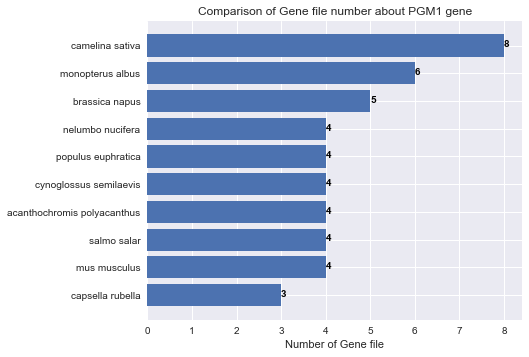

In [5]:
plot_num_file_for_species(ids_gene)

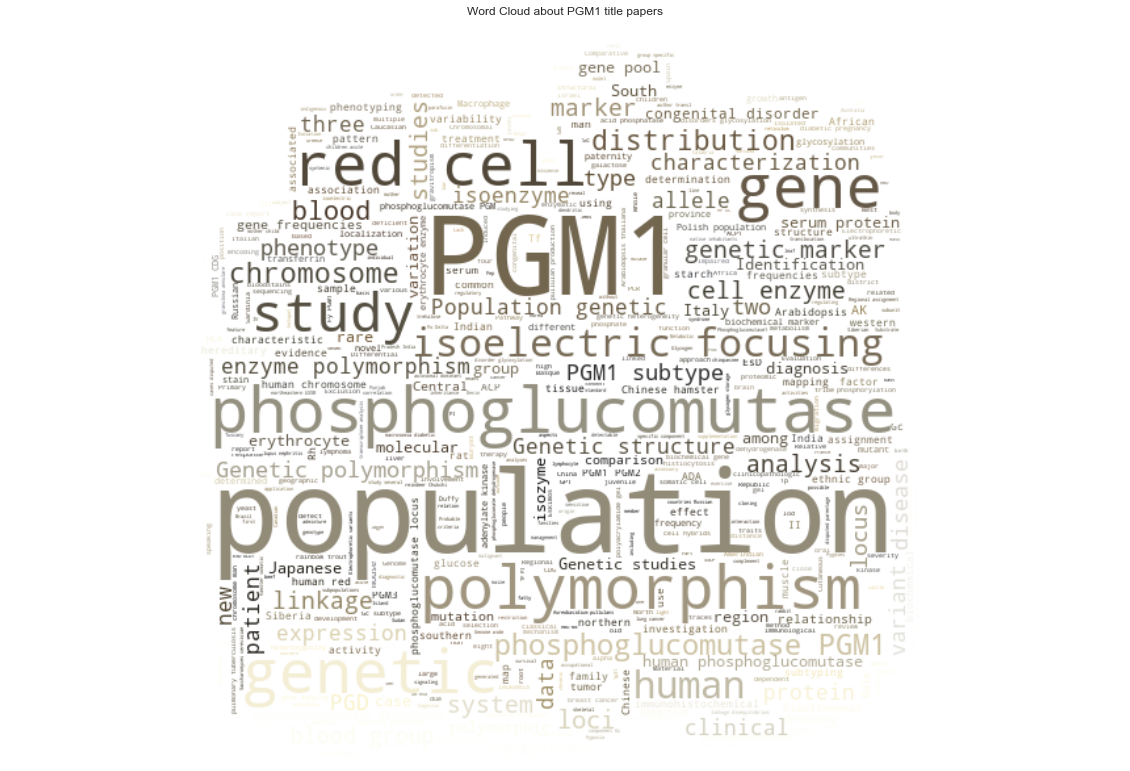

In [6]:
plot_papers_title(ids_pub)

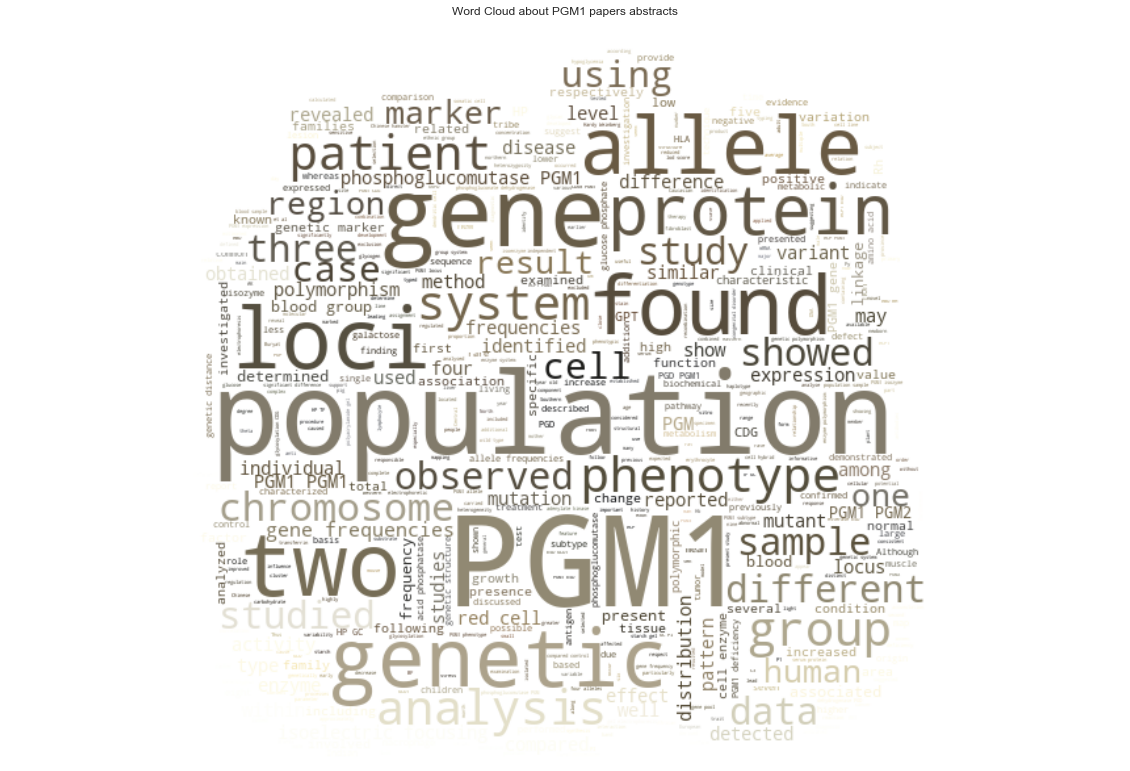

In [7]:
plot_abstract(ids_pub)

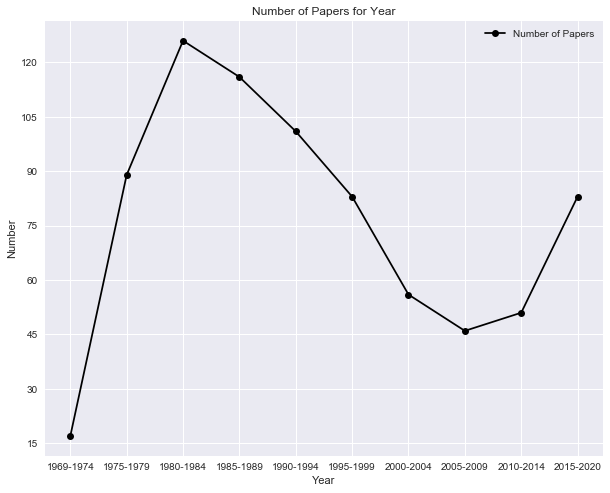

In [8]:
num_paper_for_year(ids_pub)

# https://www.omim.org/entry/171900
# https://www.ncbi.nlm.nih.gov/pubmed/30122451

20301507



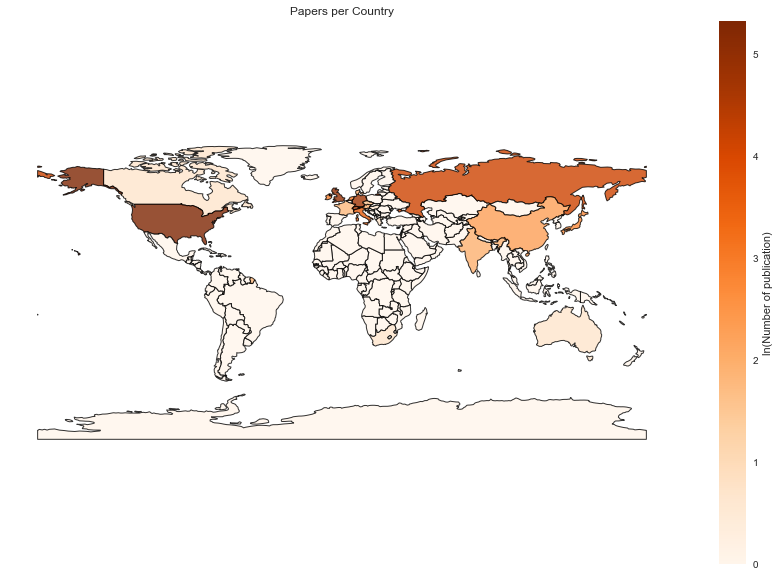

In [17]:
plot_on_world(ids_pub)

20301507



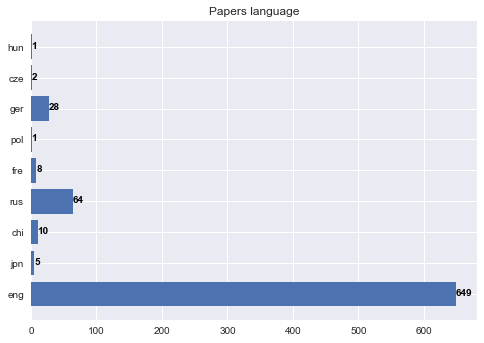

In [10]:
plot_papers_lang(ids_pub)

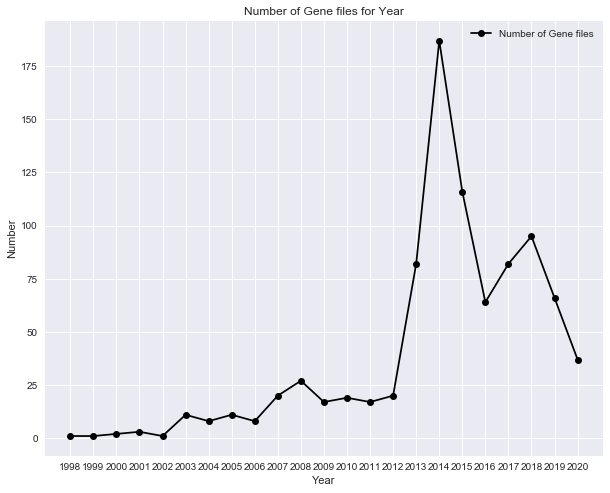

In [18]:
plot_gene_files(ids_gene)